**done remotely on greenplanet**

In [2]:
import numpy
import gdal
import osr
import glob
import xarray
import datetime
import re
import cartopy
import cmocean
import matplotlib.pyplot as mp

list the files in the directory

In [ ]:
!ls /beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2.A2018161*

open all files as a separate gdal dataset

(store in list)

In [104]:
file_list_all = numpy.array(sorted(glob.glob('/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2*.hdf')))
file_list_yearday_strings_all = numpy.array([f.split('/')[-1].split('.')[1][1:] for f in file_list_all])
file_list_datetime_all = numpy.array([datetime.datetime.strptime(yd, '%Y%j') for yd in file_list_yearday_strings_all])
yearday_strings_unique_all = numpy.unique(file_list_yearday_strings_all)

#specify which yearday to start and end on, and subset only those

print(yearday_strings_unique_all[0], yearday_strings_unique_all[-1])
yearday_start = '2001001' #yearday_strings_unique_all[0]
yearday_end = '2001020' #yearday_strings_unique_all[-1]
yearday_start_dt = datetime.datetime.strptime(yearday_start, '%Y%j')
yearday_end_dt = datetime.datetime.strptime(yearday_end, '%Y%j')
yearday_indices = [(i<=yearday_end_dt)&(i>=yearday_start_dt) for i in file_list_datetime_all]

2000049 2018177


In [105]:
file_list = file_list_all[yearday_indices]
file_list_datetime = file_list_datetime_all[yearday_indices]
file_list_yearday_strings = file_list_yearday_strings_all[yearday_indices]
yearday_strings_unique = numpy.unique(file_list_yearday_strings)

create the datetime list you'll iterate over in the data set

In [106]:
datetime_array_subset = numpy.array(([datetime.datetime.strptime(t, '%Y%j') for t in yearday_strings_unique]))

narrow file list even further by choosing only the grid cells that cover Indonesia

(corresponds to h27/28/29/30/31/32 and v08/09/10)

In [107]:
#reg_exp = re.compile('.*h(27|28|29|30|31|32)v(08|09|10)(.*\.hdf)$')
reg_exp = re.compile('.*h(27|28|29)v(08|09)(.*\.hdf)$')
file_list = numpy.array([filename for filename in file_list if re.match(reg_exp, filename)])

In [108]:
file_list

array(['/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2.A2001001.h27v08.006.2015112001047.hdf',
       '/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2.A2001001.h27v09.006.2015112001046.hdf',
       '/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2.A2001001.h28v08.006.2015112001043.hdf',
       '/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2.A2001001.h28v09.006.2015112001043.hdf',
       '/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2.A2001001.h29v08.006.2015112001043.hdf',
       '/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2.A2001001.h29v09.006.2015112001047.hdf',
       '/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2.A2001009.h27v08.006.2015112080310.hdf',
       '/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2.A2001009.h27v09.006.2015112080307.hdf',
       '/beegfs/DATA/pritchard/blangenb/MODIS_ARCHIVE/MOD11A2/MOD11A2.A2001009.h28v08.006.2015112080311.hdf',
       '/b

In [109]:
file_list.size

18

In [110]:
yearday_strings_unique.size

3

for 8-day data, nothing will be missing

1. Do the first ```yearday``` combo (using ```gdal.BuildVRT```) to get the correct x and y dim sizes

2. Then create a numpy nan array with this dimensionality.  **Make sure it's the length of the full time series, i.e., if you're missing datetimes, keep those in there as nan arrays.**  Create arrays for daytime and nighttime LST *and* the quality control data for them.

3. Loop through each daytime in the list; if it exists, get the hdf files and the data out.  If it doesn't exist, keep the arrays as nans and move on.

note the first yearday_strings_unique option ('2015238') is missing a few tiles...

In [111]:
# 1. Doing the first yearday combo
t = 0
yearday_string = yearday_strings_unique[t]
yearday_indices = [yearday_string in yd for yd in file_list]
file_list_yearday = file_list[yearday_indices]
# open only the files for that specific "yearday"
gdal_datasets = [gdal.Open(f) for f in file_list_yearday]
gdal_lst_day_data = [ds.GetSubDatasets()[0][0] for ds in gdal_datasets]
# gdal_lst_night_data = [ds.GetSubDatasets()[4][0] for ds in gdal_datasets]
# gdal_qc_day_data = [ds.GetSubDatasets()[1][0] for ds in gdal_datasets]
# gdal_qc_night_data = [ds.GetSubDatasets()[5][0] for ds in gdal_datasets]
# create mosaics
lst_day_mosaic = gdal.BuildVRT('gdal_lst_day_mosaic.vrt', gdal_lst_day_data)
# lst_night_mosaic = gdal.BuildVRT('gdal_lst_night_mosaic.vrt', gdal_lst_night_data)
# qc_day_mosaic = gdal.BuildVRT('gdal_qc_mosaic.vrt', gdal_qc_day_data)
# qc_night_mosaic = gdal.BuildVRT('gdal_qc_mosaic.vrt', gdal_qc_night_data)
# pull out data
lst_day_mosaic_data = lst_day_mosaic.ReadAsArray()
# lst_night_mosaic_data = lst_night_mosaic.ReadAsArray()
# qc_day_mosaic_data = qc_day_mosaic.ReadAsArray()
# qc_night_mosaic_data = qc_night_mosaic.ReadAsArray()

storing those data in storage arrays

In [112]:
lst_day_mosaic_ALL_DATA = numpy.zeros((datetime_array_subset.size,)+lst_day_mosaic_data.shape)*numpy.nan
#lst_night_mosaic_ALL_DATA = numpy.zeros((full_datetime_list.size,)+lst_night_mosaic_data.shape)*numpy.nan
#qc_day_mosaic_ALL_DATA = numpy.zeros((full_datetime_list.size,)+qc_day_mosaic_data.shape)*numpy.nan
#qc_night_mosaic_ALL_DATA = numpy.zeros((full_datetime_list.size,)+qc_night_mosaic_data.shape)*numpy.nan

lst_day_mosaic_ALL_DATA[0,:,:] = lst_day_mosaic_data
#lst_night_mosaic_ALL_DATA[0,:,:] = lst_night_mosaic_data
#qc_day_mosaic_ALL_DATA[0,:,:] = qc_day_mosaic_data
#qc_night_mosaic_ALL_DATA[0,:,:] = qc_night_mosaic_data

In [113]:
for t in range(1,datetime_array_subset.size):
    yearday_string = datetime_array_subset[t]
    print(yearday_string)

    yearday_string = yearday_strings_unique[t]
    yearday_indices = [yearday_string in yd for yd in file_list]
    file_list_yearday = file_list[yearday_indices]
    # open only the files for that specific "yearday"
    gdal_datasets = [gdal.Open(f) for f in file_list_yearday]
    gdal_lst_day_data = [ds.GetSubDatasets()[0][0] for ds in gdal_datasets]
    #gdal_lst_night_data = [ds.GetSubDatasets()[4][0] for ds in gdal_datasets]
    #gdal_qc_day_data = [ds.GetSubDatasets()[1][0] for ds in gdal_datasets]
    #gdal_qc_night_data = [ds.GetSubDatasets()[5][0] for ds in gdal_datasets]
    # create mosaics
    lst_day_mosaic = gdal.BuildVRT('gdal_lst_day_mosaic.vrt', gdal_lst_day_data)
    #lst_night_mosaic = gdal.BuildVRT('gdal_lst_night_mosaic.vrt', gdal_lst_night_data)
    #qc_day_mosaic = gdal.BuildVRT('gdal_qc_mosaic.vrt', gdal_qc_day_data)
    #qc_night_mosaic = gdal.BuildVRT('gdal_qc_mosaic.vrt', gdal_qc_night_data)
    # pull out data
    lst_day_mosaic_data = lst_day_mosaic.ReadAsArray()
    #lst_night_mosaic_data = lst_night_mosaic.ReadAsArray()
    #qc_day_mosaic_data = qc_day_mosaic.ReadAsArray()
    #qc_night_mosaic_data = qc_night_mosaic.ReadAsArray()
    # collect in storage arrays
    lst_day_mosaic_ALL_DATA[t,:,:] = lst_day_mosaic_data
    #lst_night_mosaic_ALL_DATA[t,:,:] = lst_night_mosaic_data
    #qc_day_mosaic_ALL_DATA[t,:,:] = qc_day_mosaic_data
    #qc_night_mosaic_ALL_DATA[t,:,:] = qc_night_mosaic_data

2001-01-09 00:00:00
2001-01-17 00:00:00


In [114]:
lst_day_mosaic_ALL_DATA.shape

(3, 2400, 3600)

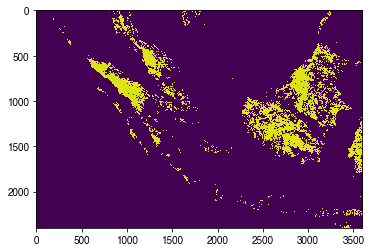

In [115]:
mp.imshow(lst_day_mosaic_data)
#mp.axes().set_xlim(0,7200)

from the documentation:

Atmospheric radiative transfer simulations were made with MODTRAN4 code (Berk et al., 1999) in wide atmospheric and LST conditions: the range of the atmospheric surface temperature (Ts-air) is set as 280–325K for the daytime and 275–305K for the nighttime; the atmospheric column water vapor varies from nearly zero to 5.5cm; and the range of (LST – Ts-air) is set as from 8–29K for daytime LSTs and from −10–4K for nighttime LSTs. A quadratic term of the difference between brightness temperatures in bands 31 and 32 was added into the original viewing angle dependent split-window algorithm in order to improve the LST retrieval accuracy slightly (Wan, 2014).

* valid range 7500-65535 in raw output

In [ ]:
# set data outside valid range equal to nan
lst_day_mosaic_ALL_DATA[(lst_day_mosaic_ALL_DATA<7500)|(lst_day_mosaic_ALL_DATA>65535)] = numpy.nan

# scale it down to Kelvin units
lst_day_mosaic_ALL_DATA_scaled = lst_day_mosaic_ALL_DATA*0.02

# take the time mean
lst_day_mosaic_timemean = numpy.nanmean(lst_day_mosaic_ALL_DATA_scaled, axis=0)

In [ ]:
mp.imshow(lst_day_mosaic_timemean-273.15);mp.colorbar()

In [ ]:
lst_geotrans = lst_day_mosaic.GetGeoTransform()
lst_geotrans

In [ ]:
data_extent = (lst_geotrans[0], \
               lst_geotrans[0] + lst_day_mosaic.RasterXSize*lst_geotrans[1], \
               lst_geotrans[3] + lst_day_mosaic.RasterYSize*lst_geotrans[5], \
               lst_geotrans[3])

In [ ]:
fontsize=12

modis_globe = cartopy.crs.Globe(datum='WGS84', ellipse='sphere', semimajor_axis=6371007.181)
map_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
data_proj = cartopy.crs.Sinusoidal(central_longitude=0, false_northing=0, false_easting=0, globe=modis_globe)
geodetic_proj = cartopy.crs.Geodetic()

field = lst_day_mosaic_timemean-273.15

fig = mp.figure(figsize=(4.25,2.75))
ax = fig.add_subplot(111, projection=map_proj)
image = ax.imshow(field, \
                  extent=data_extent, \
                  origin='upper', transform=data_proj, \
                  vmin=20,vmax=35,cmap=cmocean.cm.matter_r)
ax.coastlines(resolution='10m', color='0.1', lw=0.5)

ax.text(s='MODIS daytime LST (2017)', x=0,y=1.02,
        ha='left', va='bottom', transform=ax.transAxes,
        fontsize=fontsize)

fig.tight_layout()

axpos = ax.get_position()
cbar_ax = fig.add_axes([axpos.x0,axpos.y0-.05,axpos.width,0.05])
cbar = mp.colorbar(image, cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=fontsize)
cbar.set_label('$\degree$C', fontsize=fontsize)

mp.savefig('../figures/modis_daytime_lst_2017.png', dpi=600, bbox_inches='tight', transparent=True)